In [0]:
import pandas as pd
import numpy as np

# Preprocessing the data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
csv_file = "/content/gdrive/My Drive/Dataset_Subsystem_2.csv"

In [0]:
df = pd.read_csv(csv_file)

Let's see what our data looks like

In [0]:
df

,ID,frame,camera_facing_side,gesture,palm_root_x,palm_root_y,palm_thumb_1_x,palm_thumb_1_y,palm_thumb_2_x,palm_thumb_2_y,palm_thumb_3_x,palm_thumb_3_y,palm_index_1_x,palm_index_1_y,palm_index_2_x,palm_index_2_y,palm_index_3_x,palm_index_3_y,palm_index_4_x,palm_index_4_y,palm_middle_1_x,palm_middle_1_y,palm_middle_2_x,palm_middle_2_y,palm_middle_3_x,palm_middle_3_y,palm_middle_4_x,palm_middle_4_y,palm_ring_1_x,palm_ring_1_y,palm_ring_2_x,palm_ring_2_y,palm_ring_3_x,palm_ring_3_y,palm_ring_4_x,palm_ring_4_y,palm_pinky_1_x,palm_pinky_1_y,palm_pinky_2_x,palm_pinky_2_y,...,dorsal_root_x,dorsal_root_y,dorsal_thumb_1_x,dorsal_thumb_1_y,dorsal_thumb_2_x,dorsal_thumb_2_y,dorsal_thumb_3_x,dorsal_thumb_3_y,dorsal_index_1_x,dorsal_index_1_y,dorsal_index_2_x,dorsal_index_2_y,dorsal_index_3_x,dorsal_index_3_y,dorsal_index_4_x,dorsal_index_4_y,dorsal_middle_1_x,dorsal_middle_1_y,dorsal_middle_2_x,dorsal_middle_2_y,dorsal_middle_3_x,dorsal_middle_3_y,dorsal_middle_4_x,dorsal_middle_4_y,dorsal_ring_1_x,dorsal_ring_1_y,dorsal_ring_2_x,dorsal_ring_2_y,dorsal_ring_3_x,dorsal_ring_3_y,dorsal_ring_4_x,dorsal_ring_4_y,dorsal_pinky_1_x,dorsal_pinky_1_y,dorsal_pinky_2_x,dorsal_pinky_2_y,dorsal_pinky_3_x,dorsal_pinky_3_y,dorsal_pinky_4_x,dorsal_pinky_4_y
0,12,0,open,palm,494,295,412,266,376,243,346,225,434,186,421,156,406,125,398,99,471,170,465,130,459,88,455,60,509,171,511,130,513,100,513,71,546,187,552,160,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12,1,open,palm,493,294,410,266,375,243,345,225,433,185,420,155,404,124,396,98,469,170,464,130,458,88,453,60,508,171,509,130,512,100,512,72,545,187,551,160,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12,2,open,palm,493,294,409,267,374,243,344,225,432,185,419,155,403,124,394,97,468,170,463,129,456,89,452,60,507,171,508,130,510,100,510,72,544,186,550,160,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,12,3,open,palm,492,294,407,267,373,243,343,225,431,184,417,154,401,124,393,97,467,170,461,129,455,89,450,60,506,171,507,130,509,100,509,72,543,186,549,160,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12,4,open,palm,491,294,405,267,373,243,342,225,430,183,416,154,400,124,391,96,465,170,460,129,454,89,449,60,504,171,506,130,507,100,507,72,542,186,548,160,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62214,768,230,three_fingers,dorsal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,402,404,447,268,457,231,481,201,347,247,329,203,318,174,308,138,317,290,285,261,251,232,228,202,311,333,284,295,0,0,0,0,304,363,287,329,0,0,0,0
62215,768,231,three_fingers,dorsal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,404,405,446,267,457,230,481,201,347,247,329,204,319,174,308,139,319,291,285,262,252,233,228,202,312,334,284,295,0,0,0,0,305,363,287,330,0,0,0,0
62216,768,232,three_fingers,dorsal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,407,406,445,266,457,230,481,200,347,247,329,205,320,175,308,139,322,293,286,262,253,234,228,201,313,335,284,295,0,0,0,0,306,364,287,331,0,0,0,0
62217,768,233,three_fingers,dorsal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,410,407,444,265,456,229,481,200,348,247,329,205,320,176,308,140,325,294,286,263,254,235,228,201,314,335,284,295,0,0,0,0,307,365,287,332,0,0,0,0


Since our data contains multiple rows from the same person, there is a risk that the data from the same person ends up both in training and test set which could lead to overfitting. To avoid this data leakage, we split our dataset into training, validation and test set based on person ID. We split the dataset so that approximately 80% goes to training set, 10% to validation set and 10% to test set.

In [0]:
import random
# unique IDs
unique_ids = df['ID'].unique()

train_ids = np.random.choice(unique_ids, 41, replace=False)

test_and_val_ids = [x for x in unique_ids if x not in train_ids]
test_ids = np.random.choice(test_and_val_ids, 5, replace=False)

val_ids = [x for x in test_and_val_ids if x not in test_ids]


In [0]:
df_train = df.loc[df['ID'].isin(train_ids)]
df_test = df.loc[df['ID'].isin(test_ids)]
df_val = df.loc[df['ID'].isin(val_ids)]
df_train

,ID,frame,camera_facing_side,gesture,palm_root_x,palm_root_y,palm_thumb_1_x,palm_thumb_1_y,palm_thumb_2_x,palm_thumb_2_y,palm_thumb_3_x,palm_thumb_3_y,palm_index_1_x,palm_index_1_y,palm_index_2_x,palm_index_2_y,palm_index_3_x,palm_index_3_y,palm_index_4_x,palm_index_4_y,palm_middle_1_x,palm_middle_1_y,palm_middle_2_x,palm_middle_2_y,palm_middle_3_x,palm_middle_3_y,palm_middle_4_x,palm_middle_4_y,palm_ring_1_x,palm_ring_1_y,palm_ring_2_x,palm_ring_2_y,palm_ring_3_x,palm_ring_3_y,palm_ring_4_x,palm_ring_4_y,palm_pinky_1_x,palm_pinky_1_y,palm_pinky_2_x,palm_pinky_2_y,...,dorsal_root_x,dorsal_root_y,dorsal_thumb_1_x,dorsal_thumb_1_y,dorsal_thumb_2_x,dorsal_thumb_2_y,dorsal_thumb_3_x,dorsal_thumb_3_y,dorsal_index_1_x,dorsal_index_1_y,dorsal_index_2_x,dorsal_index_2_y,dorsal_index_3_x,dorsal_index_3_y,dorsal_index_4_x,dorsal_index_4_y,dorsal_middle_1_x,dorsal_middle_1_y,dorsal_middle_2_x,dorsal_middle_2_y,dorsal_middle_3_x,dorsal_middle_3_y,dorsal_middle_4_x,dorsal_middle_4_y,dorsal_ring_1_x,dorsal_ring_1_y,dorsal_ring_2_x,dorsal_ring_2_y,dorsal_ring_3_x,dorsal_ring_3_y,dorsal_ring_4_x,dorsal_ring_4_y,dorsal_pinky_1_x,dorsal_pinky_1_y,dorsal_pinky_2_x,dorsal_pinky_2_y,dorsal_pinky_3_x,dorsal_pinky_3_y,dorsal_pinky_4_x,dorsal_pinky_4_y
0,12,0,open,palm,494,295,412,266,376,243,346,225,434,186,421,156,406,125,398,99,471,170,465,130,459,88,455,60,509,171,511,130,513,100,513,71,546,187,552,160,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12,1,open,palm,493,294,410,266,375,243,345,225,433,185,420,155,404,124,396,98,469,170,464,130,458,88,453,60,508,171,509,130,512,100,512,72,545,187,551,160,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12,2,open,palm,493,294,409,267,374,243,344,225,432,185,419,155,403,124,394,97,468,170,463,129,456,89,452,60,507,171,508,130,510,100,510,72,544,186,550,160,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,12,3,open,palm,492,294,407,267,373,243,343,225,431,184,417,154,401,124,393,97,467,170,461,129,455,89,450,60,506,171,507,130,509,100,509,72,543,186,549,160,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12,4,open,palm,491,294,405,267,373,243,342,225,430,183,416,154,400,124,391,96,465,170,460,129,454,89,449,60,504,171,506,130,507,100,507,72,542,186,548,160,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62214,768,230,three_fingers,dorsal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,402,404,447,268,457,231,481,201,347,247,329,203,318,174,308,138,317,290,285,261,251,232,228,202,311,333,284,295,0,0,0,0,304,363,287,329,0,0,0,0
62215,768,231,three_fingers,dorsal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,404,405,446,267,457,230,481,201,347,247,329,204,319,174,308,139,319,291,285,262,252,233,228,202,312,334,284,295,0,0,0,0,305,363,287,330,0,0,0,0
62216,768,232,three_fingers,dorsal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,407,406,445,266,457,230,481,200,347,247,329,205,320,175,308,139,322,293,286,262,253,234,228,201,313,335,284,295,0,0,0,0,306,364,287,331,0,0,0,0
62217,768,233,three_fingers,dorsal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,410,407,444,265,456,229,481,200,348,247,329,205,320,176,308,140,325,294,286,263,254,235,228,201,314,335,284,295,0,0,0,0,307,365,287,332,0,0,0,0


We want to convert our data into arrays so that it can be passed to the neural network
pri




















In [0]:
dataset_train = df_train.values
dataset_test = df_test.values
dataset_val = df_val.values

We now split training, validation and test dataset into input features (landmarks) and the gestures that we want to predict

In [0]:
landmarks_train = np.hsplit(dataset_train, np.array([2, 4, 84]))[2]
gestures_train = np.hsplit(dataset_train, np.array([2, 4, 84]))[1]

landmarks_test = np.hsplit(dataset_test, np.array([2, 4, 84]))[2]
gestures_test = np.hsplit(dataset_test, np.array([2, 4, 84]))[1]

landmarks_val = np.hsplit(dataset_val, np.array([2, 4, 84]))[2]
gestures_val = np.hsplit(dataset_val, np.array([2, 4, 84]))[1]


Now there are two entries (dorsal/palm and open/first/three_fingers) for each gesture in gestures array. Instead we want to represent a single gesture by one entry in the array. After we have done that, we encode string labels to integer labels and then use OneHot encoding.

In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# Merge two columns into one
def single_column(gestures):
  gestures_column = []
  for gesture in gestures:
    gestures_column.append(gesture[0] + ' ' + gesture[1])
  return gestures_column

labels_train = single_column(gestures_train)
labels_val = single_column(gestures_val)
labels_test = single_column(gestures_test)


Using TensorFlow backend.


['open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm', 'open palm'

In [0]:
def encode_labels(labels):
  encoder = LabelEncoder()
  encoder.fit(labels)
  # Encode string labels to integer labels
  labels_encoded = encoder.transform(labels)
  # OneHot encoding
  return labels_encoded 
  
labels_train_encoded = encode_labels(labels_train)
labels_val_encoded = encode_labels(labels_val)
labels_test_encoded = encode_labels(labels_test)


labels_train = np_utils.to_categorical(labels_train_encoded)
labels_val = np_utils.to_categorical(labels_val_encoded)
labels_test = np_utils.to_categorical(labels_test_encoded)




The next step in our processing is to make sure that the scale of the input features are similar

In [0]:
from sklearn import preprocessing
# min-max scaler scales the dataset so that all the input features lie between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler()
landmarks_train = min_max_scaler.fit_transform(landmarks_train)
landmarks_val = min_max_scaler.fit_transform(landmarks_val)
landmarks_test = min_max_scaler.fit_transform(landmarks_test)

# Building the network

The first step is setting up the architecture.

In [0]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential([Dense(80, activation='sigmoid', input_shape=(80,)),
                    Dense(6, activation='softmax')])

The next step is to choose the optimizer, loss function and metrics

In [0]:
from keras.optimizers import SGD, Adam
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


We can now train our model.

In [0]:
hist = model.fit(landmarks_train, labels_train,
                 batch_size=64, epochs=10,
                 validation_data=(landmarks_val, labels_val),
                 shuffle=True, verbose=1)

Train on 49373 samples, validate on 6257 samples
Epoch 1/10
49373/49373 [==============================] - 1s 23us/step - loss: 0.3729 - accuracy: 0.9579 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 2/10
49373/49373 [==============================] - 1s 21us/step - loss: 0.0358 - accuracy: 0.9948 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 3/10
49373/49373 [==============================] - 1s 20us/step - loss: 0.0104 - accuracy: 0.9997 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 4/10
49373/49373 [==============================] - 1s 20us/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 5/10
49373/49373 [==============================] - 1s 20us/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 6.6195e-04 - val_accuracy: 1.0000
Epoch 6/10
49373/49373 [==============================] - 1s 20us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 4.6407e-04 - val_accuracy: 1.0000
Epoch 7/10
49373/49373 [==============================] - 1s 

# Visualize model training history

Here we'll create two plots:

1. A plot of accuracy on the training and validation datasets over training epochs
2. A plot of loss on the training an validation datasets over training epochs

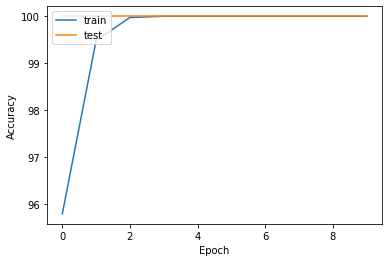

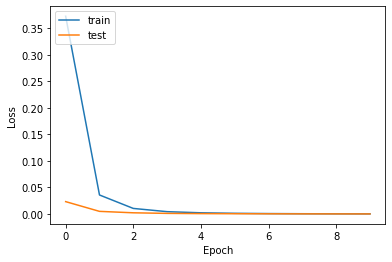

In [0]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot([x*100.0 for x in hist.history['accuracy']])
plt.plot([x*100.0 for x in hist.history['val_accuracy']])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('acc.png', bbox_inches='tight')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss.png', bbox_inches='tight')
plt.show()

In [0]:
[x * 100.0 for x in hist.history['val_accuracy']]

[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 486       
Total params: 6,966
Trainable params: 6,966
Non-trainable params: 0
_________________________________________________________________


# Predict

In [0]:
# predictions test set
predictions = model.predict(landmarks_test, batch_size = 64, verbose = 0)
rounded_predictions = model.predict_classes(landmarks_test, batch_size = 64, verbose = 0)

# predictions validation set
predictions_val = model.predict(landmarks_val, batch_size = 64, verbose = 0)
rounded_predictions_val = model.predict_classes(landmarks_val, batch_size = 64, verbose = 0)

# Confusion matrix

In [0]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools

In [0]:
cm = confusion_matrix(labels_test_encoded, rounded_predictions)
cm_val = confusion_matrix(labels_val_encoded, rounded_predictions_val)

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix_test.png', bbox_inches='tight')

Confusion matrix, without normalization
[[1159    0    0    0    0    0]
 [   0 1158    0    0    0    0]
 [   0    0 1104    0    0    0]
 [   0    0    0  995    0    0]
 [   0    0    0    0 1180    0]
 [   0    0    0    0    0  993]]


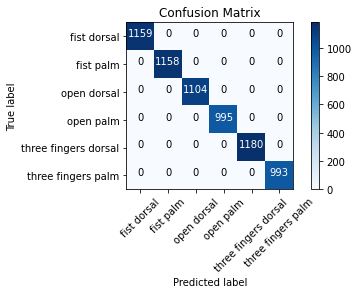

In [0]:
cm_plot_labels = ['fist dorsal', 'fist palm', 'open dorsal',
                  'open palm', 'three fingers dorsal', 'three fingers palm']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# Evaluation of model's performance

In [0]:
model.evaluate(landmarks_test, labels_test, batch_size = 64)

6589/6589 [==============================] - 0s 11us/step


[2.8145593702044493e-05, 1.0]